## Image Captioning Using Atttention Mechanism

### **Importing Libraries**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.models import Model
import pickle



keras = tf.keras

In [ ]:
max_cap_len = 15  #  max length of captioning sentences
img_dimension = 299 #  height and width of images
num_words = 10000 #  vocab size to tokenize and train on
encoding_size = 512 # dimension of the encodings of images
LSTM_size = 512
batch_size = 128
n_epochs = 15
Buffer_size = 1000 #shuffle
validation_and_test_split = 0.4
test_to_val_split = 0.8
num_examples = None # Determines number of overall read samples. If set to none all samples will be read as long as they don't exceed max_cap_len

###Browser Implementation

In [ ]:
!pip install flask-ngrok

In [ ]:
!pip install Flask-Uploads

In [ ]:
!mkdir templates -p

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading

with open('tokenizer.pickle', 'rb') as handle:
    tok = pickle.load(handle)

In [ ]:
# WORKING
%%writefile templates/upload.html
<!doctype html>
<html lang="en">
<head>
<!-- Required meta tags -->
<meta charset="utf-8">
<meta name="viewport" content="width=device-width, initial-scale=1">

 <!-- Bootstrap CSS -->
<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.0.0-beta2/dist/css/bootstrap.min.css" rel="stylesheet" integrity="sha384-BmbxuPwQa2lc/FVzBcNJ7UAyJxM6wuqIj61tLrc4wSX0szH/Ev+nYRRuWlolflfl" crossorigin="anonymous">

 </head>
<body>
  <div class="container">

    
    <div class="row">
      <div class="col-12 mt-2">
        <form class="" method=POST enctype=multipart/form-data action="{{ url_for('upload') }}">
          <!-- <label for="formFile" class="form-label">Default file input example</label> -->
         <input  class="form-control" type=file name=photo required>
      </div>
       
      </div>
      <div class="row">
      <div class="col-12 mt-2">
        <input type="submit" class="form-control btn btn-primary" onsubmit="">
        </form>
      </div>
      </div>
    
    
{% if data != null%}
      <div class="row">
      <div class="col-12 mt-2">
        <div class="form-control border border-success text-black text-center">
          {{ data }}
        </div>
      </div>



     <form class="input" id="voice-form">
   <div class="row">
      <div class="col-12 mt-2">
      <select class="form-control" name="voices" id="voices"></select>

      </div>
  </div>
  <div class="row d-flex justify-content-center">
      <div class="col-12 mt-2">
      <button class= "btn btn-primary">Say it!</button>
      </div>
      </div>
      </form>
{% endif %}
  </div>
  </div>
      



<script src="https://cdn.jsdelivr.net/npm/bootstrap@5.0.0-beta2/dist/js/bootstrap.bundle.min.js" integrity="sha384-b5kHyXgcpbZJO/tY9Ul7kGkf1S0CWuKcCD38l8YkeH8z8QjE0GmW1gYU5S9FOnJ0" crossorigin="anonymous"></script>
<script src="https://cdn.jsdelivr.net/npm/@popperjs/core@2.6.0/dist/umd/popper.min.js" integrity="sha384-KsvD1yqQ1/1+IA7gi3P0tyJcT3vR+NdBTt13hSJ2lnve8agRGXTTyNaBYmCR/Nwi" crossorigin="anonymous"></script>
<script src="https://cdn.jsdelivr.net/npm/bootstrap@5.0.0-beta2/dist/js/bootstrap.min.js" integrity="sha384-nsg8ua9HAw1y0W1btsyWgBklPnCUAFLuTMS2G72MMONqmOymq585AcH49TLBQObG" crossorigin="anonymous"></script>

<script>


var data = '{{ data }}';
      console.log(data)
      window.addEventListener('DOMContentLoaded', () => {
        const form = document.getElementById('voice-form');
       
        const main = document.getElementsByTagName('main')[0];
        const voiceSelect = document.getElementById('voices');
        let voices;
        let currentVoice;

        const populateVoices = () => {
          const availableVoices = speechSynthesis.getVoices();
          voiceSelect.innerHTML = '';

          availableVoices.forEach(voice => {
            const option = document.createElement('option');
            let optionText = `${voice.name} (${voice.lang})`;
            if (voice.default) {
              optionText += ' [default]';
              if (typeof currentVoice === 'undefined') {
                currentVoice = voice;
                option.selected = true;
              }
            }
            if (currentVoice === voice) {
              option.selected = true;
            }
            option.textContent = optionText;
            voiceSelect.appendChild(option);
          });
          voices = availableVoices;
        };

        populateVoices();
        if (speechSynthesis.onvoiceschanged !== undefined) {
          speechSynthesis.onvoiceschanged = populateVoices;
        }

        voiceSelect.addEventListener('change', event => {
          const selectedIndex = event.target.selectedIndex;
          currentVoice = voices[selectedIndex];
        });

        form.addEventListener('submit', event => {
          event.preventDefault();
          const toSay = data;
          const utterance = new SpeechSynthesisUtterance(toSay);
          utterance.voice = currentVoice;
          utterance.addEventListener('start', event => {
            main.classList.add('speaking');
          });
          utterance.addEventListener('end', event => {
            main.addEventListener(
              'animationiteration',
              event => {
                main.classList.remove('speaking');
              },
              {
                once: true
              }
            );
          });
          speechSynthesis.speak(utterance);
          data.value = '';
        });
      });
    </script>

</body>
</html>

Overwriting templates/upload.html


In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask
from flask import Flask, render_template, request
from flask_uploads import UploadSet, configure_uploads, IMAGES


def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (img_dimension, img_dimension))
  tf.convert_to_tensor(img, dtype=tf.float32)
  return img

encoder = keras.models.load_model('/content/drive/MyDrive/dhati_inception_resnet/final/5_encoder.hdf5')
decoder = keras.models.load_model('/content/drive/MyDrive/dhati_inception_resnet/final/5_decoder.hdf5')

def caption_image(path):
  img = load_img(path)
  encodings = encoder.predict(tf.reshape(img,(1,img_dimension,img_dimension,3)))

  texts = ["<sos>"]
  h = np.zeros((1,LSTM_size))
  c = np.zeros((1,LSTM_size))
  for _ in range(max_cap_len + 1):
    dec_inp = np.array(tok.word_index.get(texts[-1])).reshape(1,-1)
    #print(dec_inp)
    props,h,c = decoder.predict([encodings,h,c ,dec_inp])
    props= props[0]
    idx = np.argmax(props)
   
    texts.append(tok.index_word.get(idx))
   
    if idx == tok.word_index['<eos>']:
      break
  if tok.word_index.get(texts[-1]) != tok.word_index['<eos>']:
    texts.append('<eos>')
  texts.pop() #remove <eos>
  texts.pop(0) #remove <sos>
  a = ' '.join(texts)
  return a
 
app = Flask(__name__)
run_with_ngrok(app)   #starts ngrok when the app is run

photos = UploadSet('photos', IMAGES)

app.config['UPLOADED_PHOTOS_DEST'] = 'static'
configure_uploads(app, photos)

# load and prepare the image


@app.route('/', methods=['GET', 'POST'])
def upload():
    if request.method == 'POST' and 'photo' in request.files:
        filename = photos.save(request.files['photo'], name='sample.png')
        print(filename)
        y = "/content/COCO_val2014_000000003501.jpg"
       
        img = caption_image("/content/static/"+filename)
        # load model
       
        
        print(img)
        return render_template('upload.html',data=img)
    return render_template('upload.html')  

if __name__ == "__main__":
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://cd53c027d713.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [14/Apr/2021 15:16:54] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Apr/2021 15:16:55] "GET /favicon.ico HTTP/1.1" 404 -


sample.png


127.0.0.1 - - [14/Apr/2021 15:17:38] "POST / HTTP/1.1" 200 -


a group of people playing baseball on field
sample_1.png


127.0.0.1 - - [14/Apr/2021 15:18:00] "POST / HTTP/1.1" 200 -


a small basket full of bananas and apples


In [ ]:
#from werkzeug.utils import secure_filename
#from werkzeug.datastructures import  FileStorage

In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
print(keras.__version__)

2.4.0


### **Dataset Download**

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'

annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'

image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
PATH = os.path.dirname(image_zip) + image_folder
os.remove(image_zip)


13510574080/13510573713 [==============================] - 329s 0us/step


In [ ]:
print(PATH)

/content/train2014/


### **Pre-processing Captions**

In [ ]:
annotation_file = '/content/annotations/captions_train2014.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = annot['caption']

    #Removing the word 'a' from captions
    caption = caption.replace(" a "," ")
    caption = caption.replace("A ","")
    #Removing the word 'an' from captions
    caption = caption.replace("An ","")
    caption = caption.replace(" an "," ")
    #Removing the word 'the' from captions
    caption = caption.replace(" the "," ")
    caption = caption.replace("The ","")

    #Load only captions that don't exceed maximum length
    if len(caption.split(" ")) > max_cap_len:
      continue
    else:
      caption = '<sos> ' + caption + ' <eos>'
      image_id = annot['image_id']
      full_coco_image_path = '/content/train2014/' + 'COCO_train2014_' + '%012d.jpg' % (image_id)

      all_img_name_vector.append(full_coco_image_path)
      all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=42)
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

caption_train, captions_test, img_name_vector_train, img_name_vector_test = train_test_split(train_captions,
                                                                      img_name_vector,
                                                                      test_size= validation_and_test_split)

caption_val, caption_test, img_name_vector_val, img_name_vector_test = train_test_split(captions_test,
                                                        img_name_vector_test,
                                                        test_size= test_to_val_split)
num_samples = len(img_name_vector)
assert len(train_captions) == len(img_name_vector)
print("Loaded %d samples" %(num_samples))
print("Loaded %d train samples" %(len(caption_train)))
print("Loaded %d valid samples" %(len(caption_val)))
print("Loaded %d test samples" %(len(caption_test)))


Loaded 409297 samples
Loaded 245578 train samples
Loaded 32743 valid samples
Loaded 130976 test samples


In [ ]:
caption_val2, caption_test2, img_name_vector_val2, img_name_vector_test2 = train_test_split(caption_test,
                                                        img_name_vector_test,
                                                        test_size= 0.0084)
print(len(caption_test2),len(img_name_vector_test2))

1101 1101


In [ ]:
caption_val2, caption_test2, img_name_vector_val2, img_name_vector_test2 = train_test_split(caption_train,
                                                        img_name_vector_train,
                                                        test_size= 0.008)
print(len(caption_test2),len(img_name_vector_test2))

1965 1965


In [ ]:
tok = keras.preprocessing.text.Tokenizer(num_words = num_words
                                         ,filters ="!?,'()_-+=&*$#@.",oov_token="<unk>")
tok.fit_on_texts(caption_train)
captions_train = tok.texts_to_sequences(caption_train)
if num_words == None:
  words = len(tok.word_index)
else:
  words = num_words
captions_train = keras.preprocessing.sequence.pad_sequences(captions_train, padding='post',maxlen=max_cap_len + 2)
print("Example:", captions_train[np.random.randint(low=0, high= len(captions_train) - 1)])
print("Found %d unique words" %(words))

Example: [  2  45  13   6 139  35  42   3   0   0   0   0   0   0   0   0   0]
Found 10000 unique words


In [ ]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [ ]:
captions_valid = tok.texts_to_sequences(caption_val)
captions_valid = keras.preprocessing.sequence.pad_sequences(captions_valid, padding='post',maxlen=max_cap_len + 2)

In [ ]:
def load_img(path):
  img = tf.io.read_file(path) #reads the file
  img = tf.image.decode_jpeg(img, channels=3) #decodes a JPEG-encoded image to a uint8 tensor. uint8 tensor:data type that contains all whole numbers from 0 to 255.
  img = tf.image.resize(img, (img_dimension, img_dimension)) #resizes to 299 by 299
  return img

In [ ]:
def preprocess_func(path_index, caption):
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_train,indices=path_index)
  img = load_img(path)
  #Preprocessing text
  teacher_caption = caption[:-1] #all words of the caption except <end>
  tar_caption = caption[1:] #all words of caption except <start
  
  h_and_c_init = tf.zeros((LSTM_size))
   
  return (img,h_and_c_init,teacher_caption), tar_caption  

In [ ]:
def preprocess_func_val(path_index, caption):
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_val,indices=path_index)
  img = load_img(path)
  #Preprocessing text
  teacher_caption = caption[:-1] 
  tar_caption = caption[1:]   

  h_and_c_init = tf.zeros((LSTM_size))
  
  return (img,h_and_c_init,teacher_caption), tar_caption 

In [ ]:
#Creating an array to index each img path for reading 
path_index_vec_train = np.array(list(range(0,len(img_name_vector_train)))).reshape(-1,1) #index values from 0 to len(img_name_vector_train)reshaped to a column
path_index_vec_val = np.array(list(range(0,len(img_name_vector_val)))).reshape(-1,1)

dataset1_train = tf.data.Dataset.from_tensor_slices(path_index_vec_train) #index values
dataset2_train = tf.data.Dataset.from_tensor_slices(captions_train) # sequenced captions
dataset = tf.data.Dataset.zip((dataset1_train,dataset2_train)) # each caption will be enumerated
dataset = dataset.map(preprocess_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset1_val = tf.data.Dataset.from_tensor_slices(path_index_vec_val)
dataset2_val = tf.data.Dataset.from_tensor_slices(captions_valid)
dataset_val = tf.data.Dataset.zip((dataset1_val,dataset2_val))
dataset_val = dataset_val.map(preprocess_func_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
captions_train[:5]

array([[   2,   27,    9,   15,   19,   11, 2655,   28,   65,    3,    0,
           0,    0,    0,    0,    0,    0],
       [   2,  432,  465,  523,  350,  276,  100, 3132,  636,  428,    7,
          68,    3,    0,    0,    0,    0],
       [   2,   10,    4,  246, 9044,    6,  157,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   2,   14,  324,    6,  175,   66, 5498,  790,    3,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   2,  261,   13,    6,  289,    6,  117,   42,   52,   87,    3,
           0,    0,    0,    0,    0,    0]], dtype=int32)

In [ ]:
path_index_vec_train[:10]

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [ ]:
for i in dataset1_train:
  print(i.numpy())
  break

[0]


In [ ]:
for i in dataset2_train:
  print(i.numpy())
  break

[   2  645 9035   57 3762 1329  415   11  866 1057  231 4159    1    3
    0    0    0]


In [ ]:
dataset = dataset.shuffle(Buffer_size).batch(batch_size,drop_remainder=True).prefetch(1)
dataset_val = dataset_val.shuffle(Buffer_size).batch(256,drop_remainder=True).prefetch(1)

### **Encoder Model**

In [ ]:
model = InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(299,299,3))
IncepResnet_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-1].output) 
IncepResnet_extractor.trainable=False #will change imagenet weights if not False
print(IncepResnet_extractor.summary())

219062272/219055592 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
___________________________

In [ ]:
encoder = keras.models.Sequential([
                                   keras.layers.Lambda(preprocess_input,input_shape=(img_dimension,img_dimension,3),name="preprocessing_layer"), #Lambda layers are used for simple operations or quick experimentation.
                                   IncepResnet_extractor, #o/p of InceptionResnet
                                   keras.layers.Dense(encoding_size,activation='relu',name="encoding_layer"),
                                   keras.layers.Reshape((8*8,encoding_size),name="reshape_layer")
],name="Encoder")
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing_layer (Lambda) (None, 299, 299, 3)       0         
_________________________________________________________________
model (Functional)           (None, 8, 8, 1536)        54336736  
_________________________________________________________________
encoding_layer (Dense)       (None, 8, 8, 512)         786944    
_________________________________________________________________
reshape_layer (Reshape)      (None, 64, 512)           0         
Total params: 55,123,680
Trainable params: 786,944
Non-trainable params: 54,336,736
_________________________________________________________________


### **Attention Mechanism**

Steps in  Attention
1) Producing the Encoder Hidden States - Encoder produces hidden states of each element in the input sequence

2) Calculating Alignment Scores between the previous decoder hidden state and each of the encoder’s hidden states are calculated (Note: The last encoder hidden state can be used as the first hidden state in the decoder)

3) Softmaxing the Alignment Scores - the alignment scores for each encoder hidden state are combined and represented in a single vector and subsequently softmaxed

4) Calculating the Context Vector - the encoder hidden states and their respective alignment scores are multiplied to form the context vector

5) Decoding the Output - the context vector is concatenated with the previous decoder output and fed into the Decoder RNN for that time step along with the previous decoder hidden state to produce a new output

6) The process (steps 2-5) repeats itself for each time step of the decoder until an token is produced or output is past the specified maximum length

In [ ]:
W1 = keras.layers.Dense(512,name="W1") #encoder o/p (None,512)
W2 = keras.layers.Dense(512,name="W2") #decoder hidden (None,512)
V = keras.layers.Dense(1,name="V")
repeater = keras.layers.RepeatVector(8*8) #RepeatVector wil repeat the vector 64 times. WHY? batch size maybe
doter = keras.layers.Dot(axes=1)
concatenator = keras.layers.Concatenate()

def attention_step(enc,h_prev):
  h = repeater(h_prev) # repeats h_prev.  h_prev shape:(None,512).   h shape: (None, 64,512)
  score = tf.nn.tanh(W1(enc)+ W2(h)) # calculating alignment scores using the hidden state produced by the decoder  and the encoder output

  alphas =tf.nn.softmax(V(score),axis=1) #attention weights

  context = doter([alphas,enc]) #since context vector = attention weights*encoding values
  return context

### **Decoder Model**

In [ ]:
#Input() is used to instantiate a Keras tensor.
encodings = keras.layers.Input(shape=(8*8,encoding_size)) # (None, 64,512) 
    
init_h = keras.layers.Input(shape=(LSTM_size)) #(None,512)
init_c = keras.layers.Input(shape=(LSTM_size)) #(None,512)

teacher_forcing = keras.layers.Input(shape=(1)) #(None,1) input to Embedding layer

embedding_layer = keras.layers.Embedding(words+1,256,) 


context_prev_tar_concat_layer = keras.layers.Concatenate()
decoder_lstm_layer = keras.layers.LSTM(LSTM_size,return_state=True,dropout=0.2)
decoder_dense_layer = keras.layers.Dense(words+1,activation='softmax')

h = init_h

c = init_c

context = attention_step(encodings,h)

embedds = embedding_layer(teacher_forcing) #o/p shape: (None,1,256)

decoder_lstm_input = context_prev_tar_concat_layer([context,embedds]) #lstm input is concatinating 
  
  
h , _ , c = decoder_lstm_layer(decoder_lstm_input,initial_state=[h,c])
  
out = decoder_dense_layer(h)

decoder = keras.models.Model([encodings,init_h,init_c,teacher_forcing],[out,h,c])
decoder.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 512)]    0                                            
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 64, 512)      0           input_3[0][0]                    
__________________________________________________________________________________________________
W1 (Dense)                      (None, 64, 512)      262656      input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
# to calculate loss function
# categorical cross entropy
# adam optimizer

def sparse_it_up(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) 

  real = tf.cast(real,tf.int64)
  real = tf.one_hot(real,words+1,axis=-1)

  loss_ = tf.losses.categorical_crossentropy(real, pred)

  mask = tf.cast(mask, dtype=tf.float32)

  loss_ *= mask

  return tf.reduce_mean(loss_)


In [ ]:
# model training

optimizer = keras.optimizers.Adam()

@tf.function
def train_step(img,init_state,teacher,target):
  with tf.GradientTape() as tape: #computes multiple gradients

    encodings = encoder(img)
    h = init_state
    c = init_state
    loss = 0
    for i in range(max_cap_len+1):
      dec_inp = teacher[:,i:i+1] 
      o, h , c = decoder([encodings,h,c,dec_inp])

      loss += sparse_it_up(target[:,i],o) 

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss


In [ ]:
# This function is for forward passing features for calculating losses with no backprop

@tf.function
def valid_step(img,init_state,teacher,target):
  with tf.GradientTape() as tape:

    encodings = encoder(img)
    h = init_state
    c = init_state
    loss = 0
    
    for i in range(max_cap_len+1):
      dec_inp = teacher[:,i:i+1]
      o, h , c = decoder([encodings,h,c,dec_inp])

      loss += sparse_it_up(target[:,i],o) 

  return loss

### **Model Training**

In [ ]:
import time
EPOCHS = 5

prev_loss = np.inf #infinity 
loss_list = []

for epoch in range(EPOCHS): 
    start = time.time()
    total_loss = 0

    for (batch, ((img, s, teacher) ,target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img, s, teacher ,target)
        total_loss += t_loss

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    val_loss=0

    for (i, ((img, s, teacher) ,target)) in enumerate(dataset_val):
      val_loss += valid_step(img, s, teacher ,target)
    
    val_loss = val_loss.numpy()/((i+1)*(max_cap_len+1))
    print("val_loss=",val_loss)
    loss_list.append(val_loss)


    
    #This code makes sure we only save the best val_loss score weights
    if val_loss < prev_loss:
      print("Model_improved. Saving..")

      encoder.save("/content/drive/MyDrive/dhati_inception_resnet/final/5_encoder.hdf5")
      decoder.save("/content/drive/MyDrive/dhati_inception_resnet/final/5_decoder.hdf5")
    
    else:
      print("Model didn't improve.")

    prev_loss = val_loss

Epoch 1 Batch 0 Loss 5.5838
Epoch 1 Batch 50 Loss 3.5786
Epoch 1 Batch 100 Loss 3.5245
Epoch 1 Batch 150 Loss 3.7174
Epoch 1 Batch 200 Loss 3.4785
Epoch 1 Batch 250 Loss 3.1188
Epoch 1 Batch 300 Loss 2.8311
Epoch 1 Batch 350 Loss 2.7284
Epoch 1 Batch 400 Loss 2.5910
Epoch 1 Batch 450 Loss 2.5843
Epoch 1 Batch 500 Loss 2.4009
Epoch 1 Batch 550 Loss 2.2390
Epoch 1 Batch 600 Loss 2.2043
Epoch 1 Batch 650 Loss 2.2452
Epoch 1 Batch 700 Loss 2.2101
Epoch 1 Batch 750 Loss 2.2082
Epoch 1 Batch 800 Loss 2.0901
Epoch 1 Batch 850 Loss 2.1508
Epoch 1 Batch 900 Loss 2.1072
Epoch 1 Batch 950 Loss 1.9532
Epoch 1 Batch 1000 Loss 2.0577
Epoch 1 Batch 1050 Loss 1.9973
Epoch 1 Batch 1100 Loss 1.9557
Epoch 1 Batch 1150 Loss 2.1378
Epoch 1 Batch 1200 Loss 1.9806
Epoch 1 Batch 1250 Loss 1.9846
Epoch 1 Batch 1300 Loss 2.0748
Epoch 1 Batch 1350 Loss 1.8183
Epoch 1 Batch 1400 Loss 2.0624
Epoch 1 Batch 1450 Loss 1.8431
Epoch 1 Batch 1500 Loss 2.0159
Epoch 1 Batch 1550 Loss 1.9178
Epoch 1 Batch 1600 Loss 1.8247


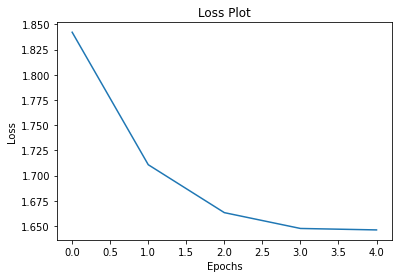

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plot")
plt.savefig('val_loss.png')

In [ ]:
# Loading 
#encoder.load_weights("/content/drive/MyDrive/inception resnet_V2_5 epochs/5_encoder.hdf5")
#decoder.load_weights("/content/drive/MyDrive/inception resnet_V2_5 epochs/5_decoder.hdf5")

In [ ]:
encoder2 = keras.models.load_model('/content/drive/MyDrive/dhati_inception_resnet/final/5_encoder.hdf5')
decoder2 = keras.models.load_model('/content/drive/MyDrive/dhati_inception_resnet/final/5_decoder.hdf5')

In [ ]:
# loading

with open('tokenizer.pickle', 'rb') as handle:
    tok = pickle.load(handle)

In [ ]:
def caption_image(path):
  image = load_img(path) #prepare image

  encodings = encoder2.predict(tf.reshape(image,(1,img_dimension,img_dimension,3)))

  texts = ["<sos>"]
  h = np.zeros((1,LSTM_size))
  c = np.zeros((1,LSTM_size))
  for _ in range(max_cap_len + 1):
    dec_inp = np.array(tok.word_index.get(texts[-1])).reshape(1,-1)
    #print(dec_inp)
    props,h,c = decoder2.predict([encodings,h,c ,dec_inp])
    props= props[0]
    idx = np.argmax(props) #probability
    
    texts.append(tok.index_word.get(idx))
    
    if idx == tok.word_index['<eos>']:
      break
  if tok.word_index.get(texts[-1]) != tok.word_index['<eos>']:
    texts.append('<eos>')
  print(' '.join(texts))
  plt.imshow(image/255.0)
  plt.axis("off")

<sos> a potted plant in some plants and plants <eos>


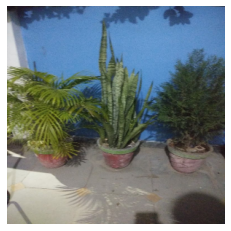

In [ ]:
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM (5).jpeg')

<sos> plant in vase on table <eos>


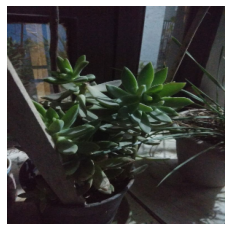

In [ ]:
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM (4).jpeg')

<sos> a plant in garden pot on table <eos>


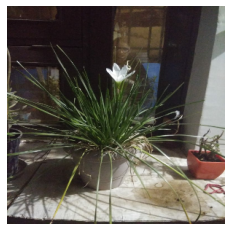

In [ ]:
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM (3).jpeg')

<sos> a close up of some food in plastic containers <eos>


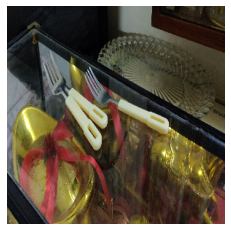

In [ ]:
caption_image('/content/IMG_20201208_191934.jpg')

<sos> computer desk with computer on top <eos>


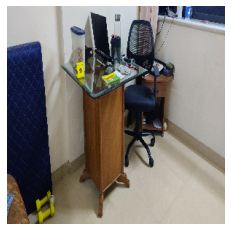

In [ ]:
caption_image('/content/IMG_20201208_191917.jpg')

<sos> man on remote in side <eos>


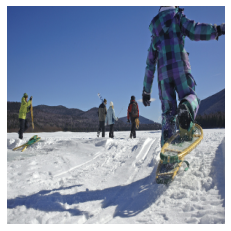

In [ ]:
caption_image(img_name_vector_test[20])

<sos> sidewalk with parking and parking in it <eos>


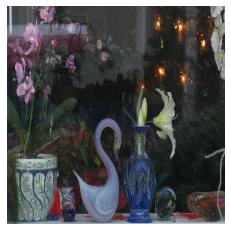

In [ ]:
caption_image(img_name_vector_test[111])

<sos> bathroom with sink toilet and bathtub <eos>


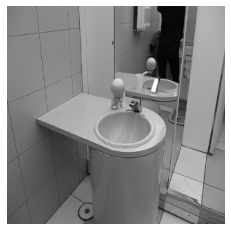

In [ ]:
caption_image(img_name_vector_test[1700])

<sos> kitchen with luggage and brown <eos>


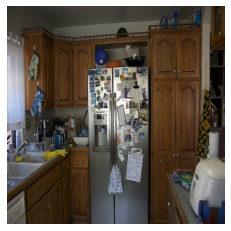

In [ ]:
caption_image(img_name_vector_test[9888])

In [ ]:
caption_image(img_name_vector_test[129])

<sos> visitor s launch with desks and boats in front of track <eos>


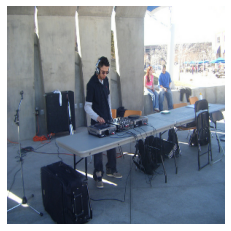

In [ ]:
caption_image(img_name_vector_test[600])

<sos> platform of man and fence picture <eos>


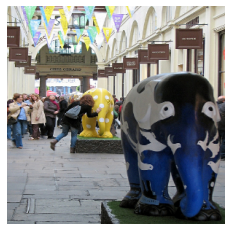

In [ ]:
caption_image(img_name_vector_test[2048])

<sos> covered is there next to horses man <eos>


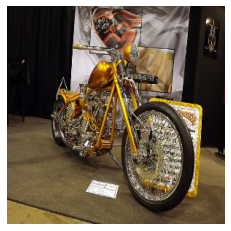

In [ ]:
caption_image(img_name_vector_test[12])

<sos> court sign is lift on top of court sign <eos>


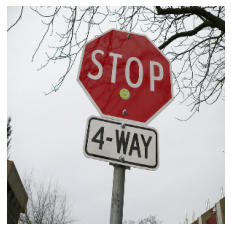

In [ ]:
caption_image(img_name_vector_test[906])

<sos> court sign is in ready of shot <eos>


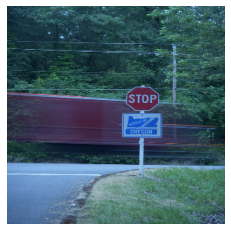

In [ ]:
caption_image(img_name_vector_test[929])

<sos> a dog sitting on from bench with his tile on from bench <eos>


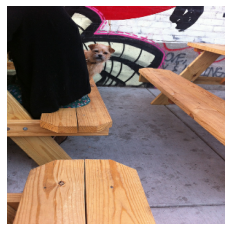

In [ ]:
caption_image(img_name_vector_test[873])

# ran now
caption_image(img_name_vector_test[2000])

<sos> bear is sitting in basket with basket on it <eos>


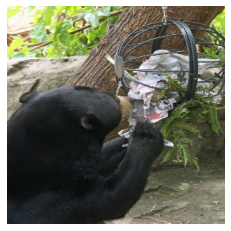

In [ ]:
# ran now
caption_image(img_name_vector_test[1100])

<sos> street sign on corner of street <eos>


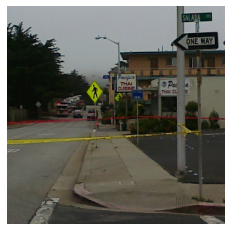

In [ ]:
# ran now
caption_image(img_name_vector_test[3000])

<sos> motorcycle parked on side of road <eos>


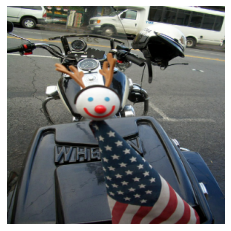

In [ ]:
# ran now
caption_image(img_name_vector_test[99])

<sos> a desk with laptop and keyboard <eos>


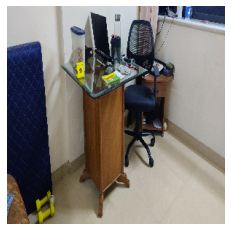

In [ ]:
# ran now
caption_image('/content/IMG_20201208_191917.jpg')

<sos> bus is driving down street with people walking around <eos>


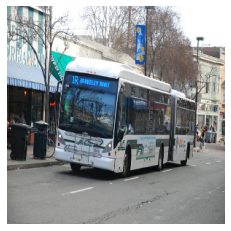

In [ ]:
caption_image('/content/drive/MyDrive/DEMO PICS/1.jpg')

<sos> two elephants are standing in field of grass <eos>


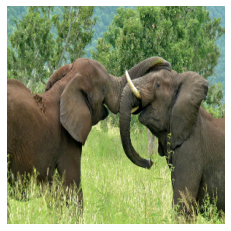

In [ ]:
caption_image('/content/drive/MyDrive/DEMO PICS/2.jpg')

<sos> two elephants are standing in field of grass <eos>


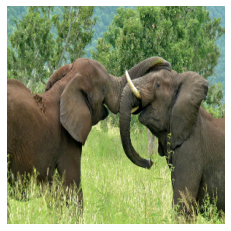

In [ ]:
#loaded
caption_image('/content/drive/MyDrive/DEMO PICS/2.jpg')

<sos> large building with clock tower on top <eos>


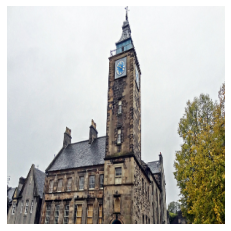

In [ ]:
caption_image('/content/drive/MyDrive/DEMO PICS/3.jpg')

<sos> large building with clock tower on top <eos>


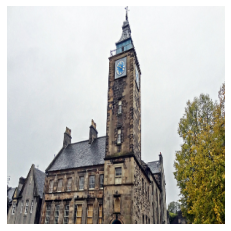

In [ ]:
caption_image('/content/drive/MyDrive/DEMO PICS/3.jpg')

<sos> man and dog are standing on beach <eos>


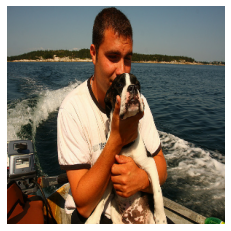

In [ ]:
caption_image('/content/drive/MyDrive/DEMO PICS/4.jpg')

<sos> bowl of fruit is sitting on table <eos>


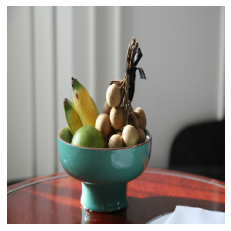

In [ ]:
caption_image('/content/drive/MyDrive/DEMO PICS/5.jpg')

<sos> man is holding bunch of bananas <eos>


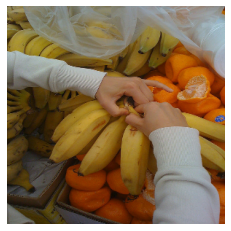

In [ ]:
caption_image('/content/drive/MyDrive/DEMO PICS/6.jpg')

<sos> stove with oven and stove in it <eos>


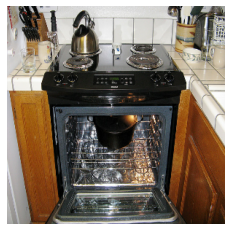

In [ ]:
caption_image('/content/drive/MyDrive/DEMO PICS/7.jpg')

<sos> two giraffes are standing in enclosure at zoo <eos>


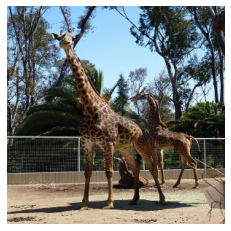

In [ ]:
caption_image('/content/drive/MyDrive/DEMO PICS/8.jpg')

<sos> man in black jacket and black shorts and black shorts and slippers <eos>


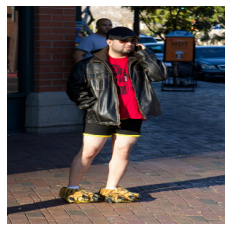

In [ ]:
caption_image('/content/drive/MyDrive/DEMO PICS/9.jpg')

<sos> giraffe is standing in front of fence <eos>


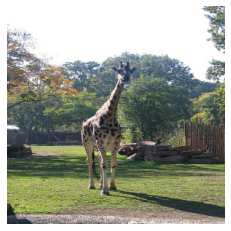

In [ ]:
caption_image('/content/drive/MyDrive/DEMO PICS/10.jpg')

<sos> dog is running in field with dog <eos>


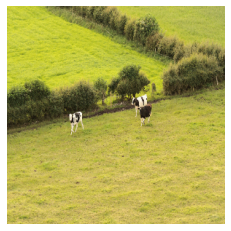

In [ ]:
caption_image('/content/drive/MyDrive/DEMO PICS/11.jpg')

<sos> man in suit is drinking from glass of wine <eos>


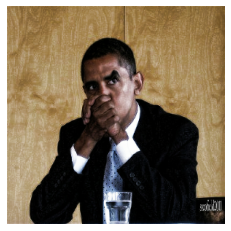

In [ ]:
caption_image('/content/drive/MyDrive/DEMO PICS/12.jpg')

<sos> woman petting dog petting dog <eos>


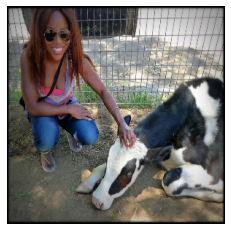

In [ ]:
caption_image('/content/drive/MyDrive/DEMO PICS/13.jpg')

<sos> a bathroom with toilet and sink <eos>


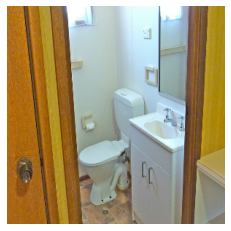

In [ ]:
caption_image('/content/drive/MyDrive/DEMO PICS/15.jpg')

<sos> person on snowboard going down hill <eos>


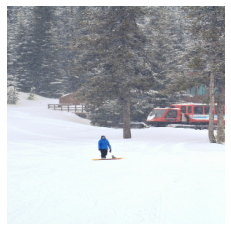

In [ ]:
caption_image('/content/drive/MyDrive/DEMO PICS/16.jpg')

<sos> a red and white truck is parked on street <eos>


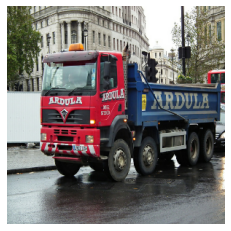

In [ ]:
caption_image('/content/drive/MyDrive/DEMO PICS/17.jpg')

##Evaluation 

In [ ]:
def caption_image_BLEU(path):
  image = load_img(path)

  encodings = encoder2.predict(tf.reshape(image,(1,img_dimension,img_dimension,3)))

  texts = ["<sos>"]
  h = np.zeros((1,LSTM_size))
  c = np.zeros((1,LSTM_size))
  for _ in range(max_cap_len + 1):
    dec_inp = np.array(tok.word_index.get(texts[-1])).reshape(1,-1)
    #print(dec_inp)
    props,h,c = decoder2.predict([encodings,h,c ,dec_inp])
    props= props[0]
    idx = np.argmax(props)
    
    texts.append(tok.index_word.get(idx))
    
    if idx == tok.word_index['<eos>']:
      break
  if tok.word_index.get(texts[-1]) != tok.word_index['<eos>']:
    texts.append('<eos>')
  prediction = ' '.join(texts)
  plt.imshow(image/255.0)
  plt.axis("off")
  return prediction

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
HERE


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)




BLEU-1: 0.017286
BLEU-2: 0.131474
BLEU-3: 0.296009
BLEU-4: 0.362594


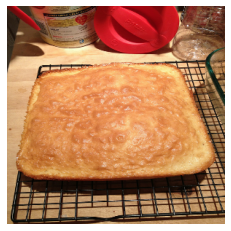

In [ ]:
def evaluate_model(encoder,decoder, img_name_vector_val2, caption_val2, log=False):
    actual, predicted = list(), list()
    # step over the whole set
    i=0
    counter = 0
    for key, desc_list in zip(img_name_vector_val2, caption_val2):
        # generate description
        i+=1
        #progressBar(i, len(caption_val), bar_length=20,job='Evaluating')
        pred = caption_image_BLEU(key)
        # store actual and predicted
        references = desc_list.split()
        actual.append(references)
        predicted.append(pred.split())
        counter = counter+1
        if counter%100 == 0:
            print(counter) 
    # calculate BLEU score
    print("HERE")
    b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\n')
    print('BLEU-1: %f' % b1)
    print('BLEU-2: %f' % b2)
    print('BLEU-3: %f' % b3)
    print('BLEU-4: %f' % b4)
    return [b1, b2, b3, b4]
b1, b2, b3, b4 = evaluate_model(encoder2,decoder2, img_name_vector_test2,caption_test2)

<sos> plate of food with glass of wine <eos>


AttributeError: ignored

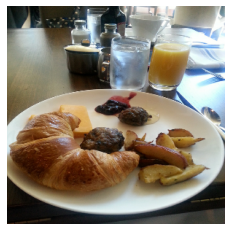

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(encoder,decoder, img_name_vector_val2, caption_val2, log=False):
    actual, predicted = list(), list()
    # step over the whole set
    i=0
    counter = 0
    for key, desc_list in zip(img_name_vector_val2, caption_val2):
        # generate description
        i+=1
        #progressBar(i, len(caption_val), bar_length=20,job='Evaluating')
        pred = caption_image_BLEU(key)
        # store actual and predicted
        references = desc_list.split()
        actual.append(references)
        predicted.append(pred.split())
        counter = counter+1
        if counter%100 == 0:
            print(counter)
           
    # calculate BLEU score
    print("HERE")
    b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\n')
    print('BLEU-1: %f' % b1)
    print('BLEU-4: %f' % b4)
    return [b1, b4]

b1,  b4 = evaluate_model(encoder2,decoder2, img_name_vector_test2, caption_test2)